# LSTM-West-Texas-Price-Forecasting-ERCOT

The idea behind this project is to forecast energy price spikes in WEST_HUB (West Texas) settlement prices. By forecasting when energy price spikes occur in West Texas, we can enable battery companies to more efficiently perform energy arbitrage and optimize their charge/discharge timing.

### Value Proposition Of Project:

A battery storage system in West Texas can capture significant arbitrage opportunities by charging during low-price periods and discharging during high-price spikes. For example, a battery could charge at $25/MWh during off-peak hours and sell at $800/MWh during extreme price events. The ML project predicts West Texas settlement prices with a focus on identifying when price spikes will occur, enabling battery storage companies to optimize their operational timing and maximize revenue.

By forecasting this complex system where supply, demand, transmission constraints, and weather all influence prices, we can create profitable opportunities for energy storage deployment and operation.

### Scope:

I will focus exclusively on ERCOT's West Texas load zone (WEST_HUB), using historical settlement point price data to build an LSTM model that predicts hourly and daily price movements. The model will identify price spike opportunities by forecasting when West Texas prices will exceed certain thresholds (e.g., >$100/MWh), enabling battery storage companies to optimize their charge/discharge timing and maximize arbitrage profits in this specific geographic region.

## 1. Importing and Cleaning Data:

In [5]:
import pandas as pd

hourly_ercot_dam_settlement_data = pd.read_csv(r"..\Data\filter_merged_ercot_data.csv")
print(hourly_ercot_dam_settlement_data.isna().sum())


hourly_ercot_dam_settlement_data = hourly_ercot_dam_settlement_data[
    hourly_ercot_dam_settlement_data['SettlementPoint'] != 'HB_NORTH'
].reset_index(drop=True)

print("\nSettlement points after filtering:")
print(hourly_ercot_dam_settlement_data['SettlementPoint'].value_counts())
hourly_ercot_dam_settlement_data = hourly_ercot_dam_settlement_data.drop('Unnamed: 0', axis=1)
hourly_ercot_dam_settlement_data.head()



Unnamed: 0              0
DeliveryDate            0
HourEnding              0
SettlementPoint         0
SettlementPointPrice    0
DSTFlag                 0
dtype: int64

Settlement points after filtering:
SettlementPoint
HB_WEST    26305
Name: count, dtype: int64


,DeliveryDate,HourEnding,SettlementPoint,SettlementPointPrice,DSTFlag
0,2022-01-02,01:00,HB_WEST,23.46,N
1,2022-01-02,02:00,HB_WEST,21.96,N
2,2022-01-02,03:00,HB_WEST,21.93,N
3,2022-01-02,04:00,HB_WEST,20.51,N
4,2022-01-02,05:00,HB_WEST,20.43,N


## 2. Preliminary EDA:

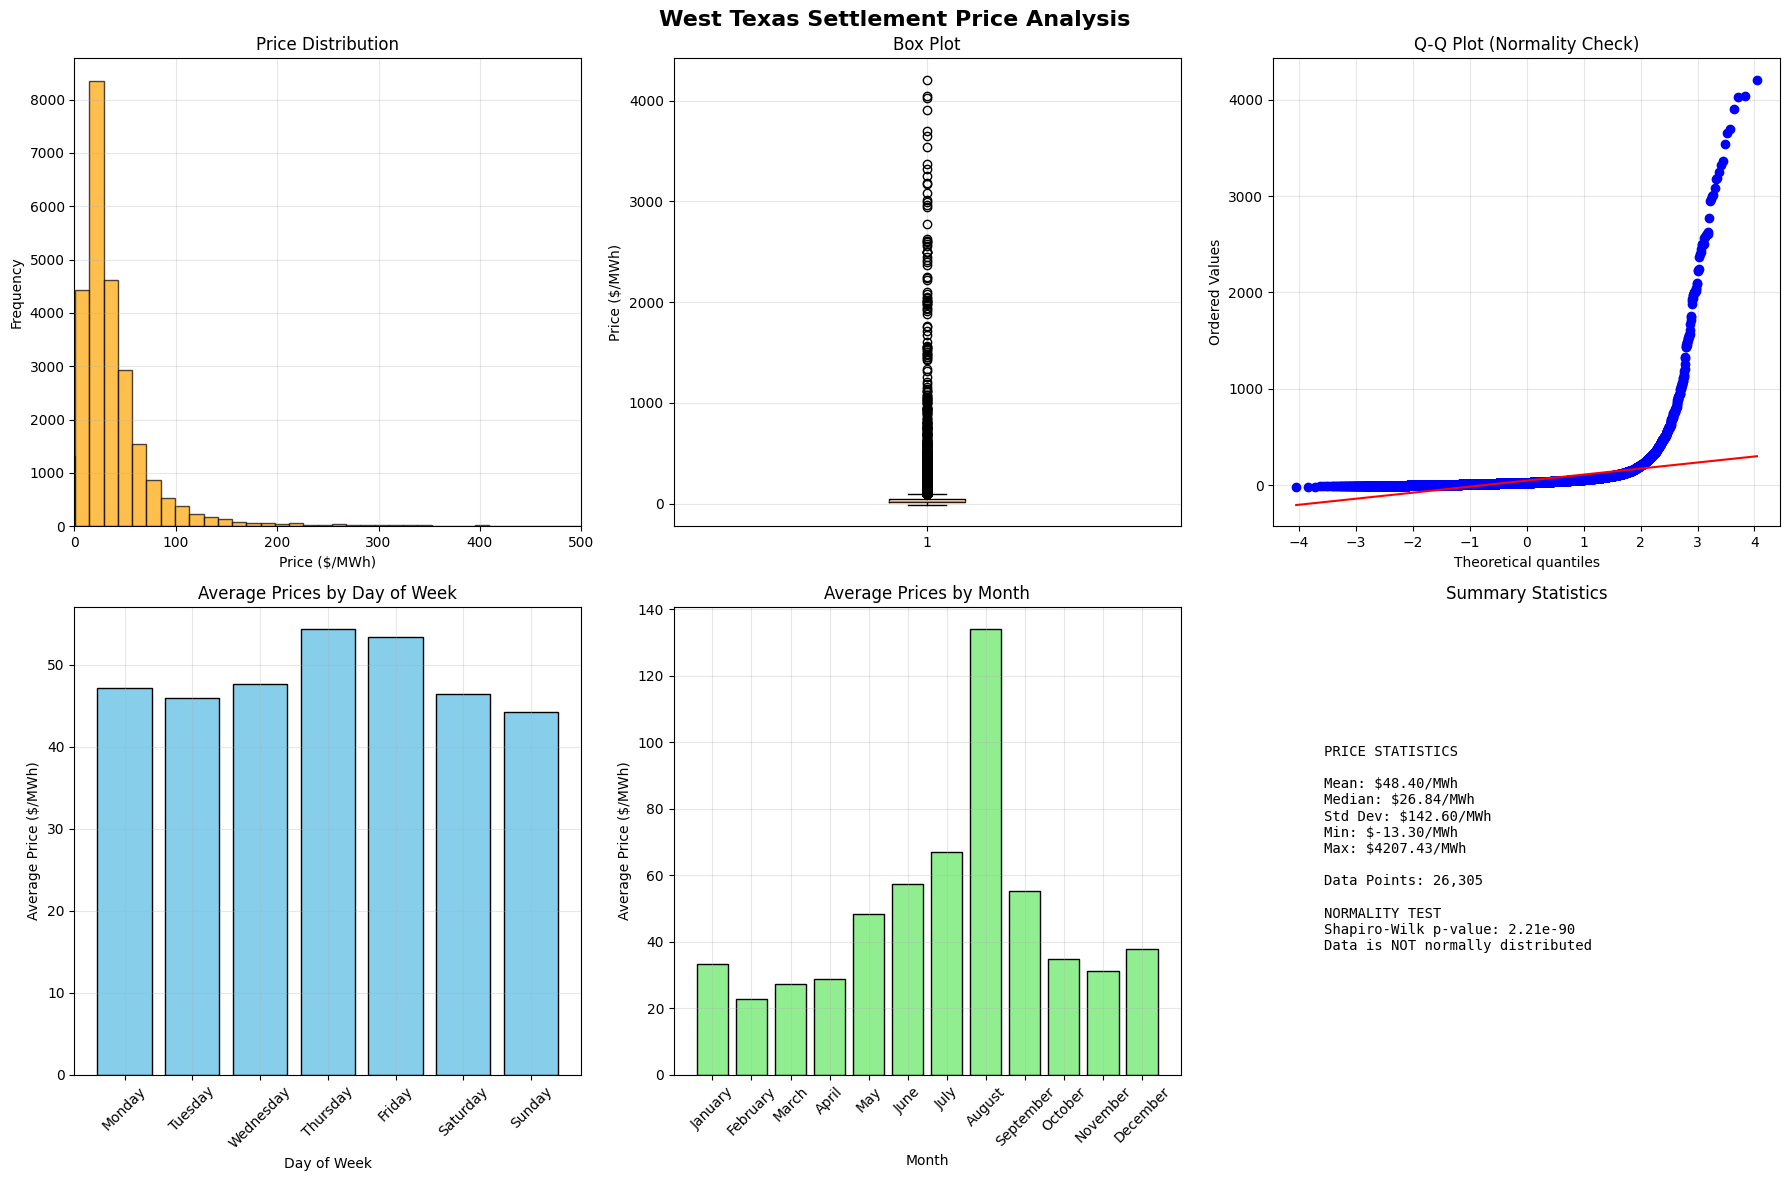

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats


hourly_ercot_dam_settlement_data['DeliveryDate'] = pd.to_datetime(hourly_ercot_dam_settlement_data['DeliveryDate'])
hourly_ercot_dam_settlement_data['DayOfWeek'] = hourly_ercot_dam_settlement_data['DeliveryDate'].dt.day_name()
hourly_ercot_dam_settlement_data['Month'] = hourly_ercot_dam_settlement_data['DeliveryDate'].dt.month_name()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('West Texas Settlement Price Analysis', fontsize=16, fontweight='bold')

# 1. Histogram
axes[0, 0].hist(hourly_ercot_dam_settlement_data['SettlementPointPrice'], bins=300, alpha=0.7, color='orange', edgecolor='black')
axes[0, 0].set_xlabel('Price ($/MWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlim(0, 500)
axes[0, 0].grid(True, alpha=0.3)

# 2. Box Plot
axes[0, 1].boxplot(hourly_ercot_dam_settlement_data['SettlementPointPrice'])
axes[0, 1].set_ylabel('Price ($/MWh)')
axes[0, 1].set_title('Box Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot
stats.probplot(hourly_ercot_dam_settlement_data['SettlementPointPrice'], dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot (Normality Check)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Average prices by day of week
day_avg = hourly_ercot_dam_settlement_data.groupby('DayOfWeek')['SettlementPointPrice'].mean()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = day_avg.reindex(day_order)

axes[1, 0].bar(day_avg.index, day_avg.values, color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Day of Week')
axes[1, 0].set_ylabel('Average Price ($/MWh)')
axes[1, 0].set_title('Average Prices by Day of Week')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 5. Average prices by month
month_avg = hourly_ercot_dam_settlement_data.groupby('Month')['SettlementPointPrice'].mean()
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
month_avg = month_avg.reindex(month_order)

axes[1, 1].bar(month_avg.index, month_avg.values, color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Price ($/MWh)')
axes[1, 1].set_title('Average Prices by Month')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# 6. Summary statistics as text
stats_text = f"""
PRICE STATISTICS

Mean: ${hourly_ercot_dam_settlement_data['SettlementPointPrice'].mean():.2f}/MWh
Median: ${hourly_ercot_dam_settlement_data['SettlementPointPrice'].median():.2f}/MWh
Std Dev: ${hourly_ercot_dam_settlement_data['SettlementPointPrice'].std():.2f}/MWh
Min: ${hourly_ercot_dam_settlement_data['SettlementPointPrice'].min():.2f}/MWh
Max: ${hourly_ercot_dam_settlement_data['SettlementPointPrice'].max():.2f}/MWh

Data Points: {len(hourly_ercot_dam_settlement_data):,}
"""

# Normality test
shapiro_stat, shapiro_p = stats.shapiro(hourly_ercot_dam_settlement_data['SettlementPointPrice'].sample(5000))
normality_text = f"\nNORMALITY TEST\nShapiro-Wilk p-value: {shapiro_p:.2e}\n"
if shapiro_p < 0.05:
    normality_text += "Data is NOT normally distributed"
else:
    normality_text += "Data appears normally distributed"

axes[1, 2].text(0.1, 0.5, stats_text + normality_text, transform=axes[1, 2].transAxes, 
                fontsize=10, verticalalignment='center', fontfamily='monospace')
axes[1, 2].set_title('Summary Statistics')
axes[1, 2].axis('off')  


plt.tight_layout()
plt.show()

## 3. Basic Data Preparation For LSTM Model Prototyping

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import numpy as np